In [3]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np

## Load all the unique sequences
These are the results for searching a database for homologues of:
- thioamide
- macroamidine
- azoline

In [4]:
seqdump_dirs = glob.glob("**/**seqdump.txt",recursive = True)
unique_sequence_ids = []
unique_sequences = []
i = 0
for seqdump_dir in tqdm(seqdump_dirs, desc='Loading all sequences'):
    seqrec_iter = SeqIO.parse(seqdump_dir,"fasta")
    for seqrec in seqrec_iter:
        i += 1
        if seqrec.id not in unique_sequence_ids:
            unique_sequence_ids.append(seqrec.id)
            unique_sequences.append(seqrec)
print(f'From {i} searched sequences {len(unique_sequences)} are unique. Loaded in unique_sequences variable.')

Loading all sequences:   0%|          | 0/24 [00:00<?, ?it/s]

From 58329 searched sequences 19057 are unique. Loaded in unique_sequences variable.


## Truncate sequences for faster processing (top 1000) -> skip for full pipeline

In [46]:
unique_sequences = unique_sequences[:100]

## Save unique sequences to file for intermediate bash processing

In [5]:
file_dir = './processed_sequences/'
unique_seq_fp = os.path.join(file_dir, "unique_unaligned_sequences.txt")
SeqIO.write(unique_sequences, unique_seq_fp, "fasta")

19057

## Remove Sequences with High Similarity using CD-HIT eg. 90% or 70% identity etc

In [13]:
identity_percentage = 0.5
filtered_by_identity_unique_seq_fp = os.path.join(file_dir, f"unique_filtered_{identity_percentage}_sequences.txt")

!./external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i $unique_seq_fp -o $filtered_by_identity_unique_seq_fp -c $identity_percentage -n 3 -d 0 -T 8 -M 16000

num_sequences = len([seq.id for seq in SeqIO.parse(filtered_by_identity_unique_seq_fp,"fasta")])
print(f"Started with {len(unique_sequences)} sequences, after removing those with >{identity_percentage*100}% identity, we have {num_sequences} sequences!")

Program: CD-HIT, V4.8.1 (+OpenMP), Dec 12 2022, 14:05:50
Command: ./external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i
         ./processed_sequences/unique_unaligned_sequences.txt
         -o
         ./processed_sequences/unique_filtered_0.5_sequences.txt
         -c 0.5 -n 3 -d 0 -T 8 -M 16000

Started: Mon Dec 12 18:02:16 2022
                            Output                              
----------------------------------------------------------------
total seq: 19057
longest and shortest : 1344 and 69
Total letters: 10313971
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 12M
Buffer          : 8 X 11M = 88M
Table           : 2 X 0M = 0M
Miscellaneous   : 0M
Total           : 101M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 1987258229

# comparing sequences from          0  to       1905
.---------- new table with      163 representatives
# comparing sequences from   

## Compute aligned sequences using mafft

In [15]:

aligned_unique_seq_fp = os.path.join(file_dir, f"aligned_{identity_percentage}_identity_sequences.txt")

!mafft --auto --distout $filtered_by_identity_unique_seq_fp > $aligned_unique_seq_fp 

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 16 ambiguous characters.
 1701 / 1710
done.

Constructing a UPGMA tree (efffree=0) ... 
 1700 / 1710
done.

Progressive alignment 1/2... 
STEP   228 / 1709 
Reallocating..done. *alloclen = 4050
STEP   280 / 1709 
Reallocating..done. *alloclen = 5241
STEP  1201 / 1709 
Reallocating..done. *alloclen = 8522
STEP  1301 / 1709 
Reallocating..done. *alloclen = 9613
STEP  1401 / 1709 
Reallocating..done. *alloclen = 13422
STEP  1601 / 1709 
Reallocating..done. *alloclen = 14687
STEP  1701 / 1709  h
done.

Making a distance matrix from msa.. 
 1700 / 1710
done.

Constructing a UPGMA tree (efffree=1) ... 
 1700 / 1710
done.

Progressive alignment 2/2... 
STEP   801 / 1709 
Reallocating..done. *alloclen = 3872
STEP  1501 / 1709 
Reallocating..done. *alloclen = 4953
STEP  1601 / 1709 
Reallocating..done. *alloclen = 6225

Reallocating

In [16]:
aligned_sequences = [seqrec for seqrec in SeqIO.parse(aligned_unique_seq_fp,"fasta")]

## Find redundant sequences to save compute

In [68]:
def pairwise_sequence_identity(seq_rec_1, seq_rec_2):
    seq_1 = str(seq_rec_1.seq)
    seq_2 = str(seq_rec_2.seq)
    
    num_matching = 0
    length = 0
    for i in range(len(seq_1)):
        if seq_1[i] == '-' and seq_2[i] == '-':
            continue
        if seq_1[i] == seq_2[i]:
            num_matching += 1
        length += 1
    return num_matching/length
seq_1, seq_2 = aligned_sequences[:2]
print(f'Sequence identity test between\nseq 1: {str(seq_1.seq)[:200]}...\nand\nseq 2: {str(seq_2.seq)[:200]}...')
identity_similarity = pairwise_sequence_identity(seq_1, seq_2)
print(f'Identity similarity = {identity_similarity}')

Sequence identity test between
seq 1: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
and
seq 2: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
Identity similarity = 0.9601769911504425


In [69]:
redundant_sequences = set()
threshold = 0.7 # anything above 70% identity to the current seq will be filtered out

pbar = tqdm(enumerate(aligned_sequences), desc='Filtering sequences', total=len(aligned_sequences))
for i, sequence in pbar:
    if i in redundant_sequences:
        continue
    comparison_sequences = [(seq, j) for j, seq in enumerate(aligned_sequences) if j != i and j not in redundant_sequences]
    for comp_seq, comp_seq_idx in comparison_sequences:
        identity_similarity = pairwise_sequence_identity(sequence, comp_seq)
        if identity_similarity > threshold: # if above threshold, then flag as redundant
            redundant_sequences.add(comp_seq_idx)
            pbar.set_description(f'Filtering sequences, found {len(redundant_sequences)} redundant')
#             print(f'Found {i} has redundant sequence with {identity_similarity*100:.2f}% similarity.')
#             print(f'We have {len(redundant_sequences)} redundant sequences.')

Filtering sequences, found 32 redundant:   0%|          | 36/19457 [06:08<55:11:27, 10.23s/it]


KeyboardInterrupt: 

In [57]:
filtered_sequences = [seq for i, seq in enumerate(aligned_sequences) if i not in redundant_sequences]

100%|██████████| 45/45 [00:00<00:00, 132.32it/s]


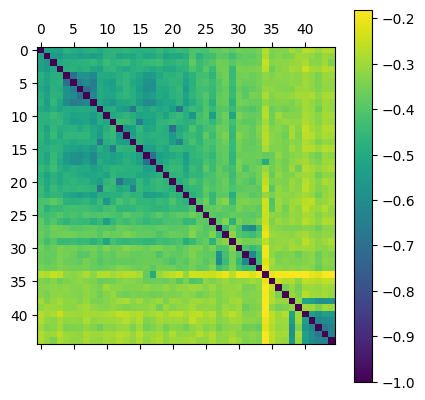

In [62]:
similarity_matrix = []

for i in tqdm(range(len(filtered_sequences))):
    row = []
    for j in range(len(filtered_sequences)):
        similarity = pairwise_sequence_identity(filtered_sequences[i], filtered_sequences[j])
        row.append(similarity)
    similarity_matrix.append(row)

m = np.array(similarity_matrix)
plt.matshow(-m)
plt.colorbar()

In [54]:
redundant_sequences

{1,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 39,
 41,
 42,
 44,
 48,
 49,
 50,
 51,
 52,
 55,
 56,
 57,
 58,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 81,
 85,
 91,
 92,
 96,
 97,
 98}

In [30]:
len(aligned_sequences)

999